# Get and Extract Signals from Signavio sources: API calls to workspaces and load from saved JSON files 
This notebook provides a collection of cells where we extract Signals from several workspaces by means of Signavio API backend calls.
You would need Signavio credentials - check if you can access:

https://editor.signavio.com/g/statics/pi/areas

Create *.env* file
```js
MY_SIGNAVIO_PASSWORD=*****
MY_SIGNAVIO_NAME=alexey.streltsov@sap.com
```


# Credentials / API  initialization

In [1]:
# Define your access to Signavio UI here or in bash env
#%env MY_SIGNAVIO_PASSWORD=*****
#%env MY_SIGNAVIO_NAME=alexey.streltsov@sap.com

# Or via .env file
#! pip install python-dotenv
from dotenv import load_dotenv
from pathlib import Path  # Python 3.6+ only
import sys
import os
sys.path.append("./")
env_path = Path('..') / '.env'
load_dotenv(dotenv_path=env_path)

! echo $MY_SIGNAVIO_NAME



alexey.streltsov@sap.com


In [2]:
# Class coped and modified  from https://github.com/signavio/bpmn2constraints/blob/main/tutorial/SignavioAuthenticator.py
class SignavioAuthenticatorCoE:
    def __init__(self, system_instance, tenant_id, email, pw):
        self.system_instance = system_instance
        self.tenant_id = tenant_id
        self.email = email
        self.pw = pw

    """
    Takes care of authentication against Signavio systems
    """

    def authenticate(self):
        """
        Authenticates user at Signavio system instance and initiates session.
        Returns:
            dictionary: Session information
        """
        login_url = self.system_instance + "/p/login"
        data = {"name": self.email, "password": self.pw, "tokenonly": "true"}
        #if "tenant_id" in locals():
        #    data["tenant"] = self.tenant_id
        data["tenant"] = self.tenant_id
        # authenticate
        login_request = requests.post(login_url, data)

        # retrieve token and session ID
        auth_token = login_request.content.decode("utf-8")
        jsesssion_ID = login_request.cookies["JSESSIONID"]

        # The cookie is named 'LBROUTEID' for base_url 'editor.signavio.com'
        # and 'editor.signavio.com', and 'AWSELB' for base_url
        # 'app-au.signavio.com' and 'app-us.signavio.com'
        lb_route_ID = login_request.cookies["LBROUTEID"]

        # return credentials
        return {
            "jsesssion_ID": jsesssion_ID,
            "lb_route_ID": lb_route_ID,
            "auth_token": auth_token,
        }

def credentials_actualization(system_instance, workspace_id, user_name, pw, auth={}):
    # get credentials for current session. They are valid for 24 hours 
    authenticator = SignavioAuthenticatorCoE(system_instance, workspace_id, user_name, pw)
    auth_data = authenticator.authenticate()
    cookies = {'JSESSIONID': auth_data['jsesssion_ID'], 'LBROUTEID': auth_data['lb_route_ID']}
    headers = {'Accept': 'application/json', 'x-signavio-id':  auth_data['auth_token']}
    print(auth_data['jsesssion_ID'],auth_data['lb_route_ID'])
    print(auth_data['auth_token'])
    auth[workspace_name]={"cookies":cookies,"headers":headers}
    return auth    

In [3]:
# select workspace here 
import json
import pathlib
import logging
import requests
import os
logging.getLogger("urllib3").setLevel(logging.WARNING)


auth={}
 
user_name = os.environ.get('MY_SIGNAVIO_NAME','alexey.streltsov@sap.com') # username
pw = os.environ.get('MY_SIGNAVIO_PASSWORD', None) # Signavio password
print("Your are:",user_name)
system_instance = 'https://editor.signavio.com'
workspace_id = 'b0f07deabd3140aea5344baa686e0d84' # workspace Process AI 
workspace_name="Process AI"
credentials_actualization(system_instance, workspace_id, user_name, pw, auth=auth) 
workspace_id = 'ccf98b692d1d4e0aa895df3aab8cd905' # workspace Solutions Demo Workspace access by alexandra.dang@sap.com
workspace_name="Solutions Demo Workspace"
credentials_actualization(system_instance, workspace_id, user_name, pw, auth=auth)
# This workspace is under discussion with sarah.roessler@sap.com
#workspace_id = "2da9ebfecca0479398ad9905b88c5187"
#workspace_name="SAP Signavio Suite Power Challenge"
#user_name="demo+113@signavio.com"
#pw="signavio"
#credentials_actualization(system_instance, workspace_id, user_name, pw, auth=auth)

auth

Your are: alexey.streltsov@sap.com
BDDA85B7B96C9528019A689714091F3F "ac423a07e50c6e3f"
e35c772889f7476fac5bba8811851045
AC2C1CD401241FA29474F62B9B35A017 "564b969e7bc94720"
453721c3ac2b44e38f5ef793daf72038


{'Process AI': {'cookies': {'JSESSIONID': 'BDDA85B7B96C9528019A689714091F3F',
   'LBROUTEID': '"ac423a07e50c6e3f"'},
  'headers': {'Accept': 'application/json',
   'x-signavio-id': 'e35c772889f7476fac5bba8811851045'}},
 'Solutions Demo Workspace': {'cookies': {'JSESSIONID': 'AC2C1CD401241FA29474F62B9B35A017',
   'LBROUTEID': '"564b969e7bc94720"'},
  'headers': {'Accept': 'application/json',
   'x-signavio-id': '453721c3ac2b44e38f5ef793daf72038'}}}

## Example how to run manually -constructed SIGNALS against workspace DB:

In [4]:
# Run manually -constructed SIGNALS need for VIEW 
def signal_template(signal,view):
    return f'SELECT {signal} FROM "{view}"'
signal_endpoint = system_instance + '/g/api/pi-graphql/signal'

workspace_name="Solutions Demo Workspace"
#workspace_name="Process AI"
#workspace_name="SAP Signavio Suite Power Challenge"

# https://editor.signavio.com/g/statics/pi/areas/ba-3/processes/test00-1/views/defaultview-2
# https://editor.signavio.com/g/statics/pi/areas/etl-403/processes/sl-itc-dashboard-test-1/views/defaultview-529
view="defaultview-529" # for workspace_name="Solutions Demo Workspace"
#view="strview-1" 
#view="defaultview-35"
signal='AVG( (SELECT LAST(end_time) - FIRST(end_time)))'
q = {'query': signal_template(signal=signal,view=view)}
q = {'query': 'SELECT count(1) \nFROM FLATTEN("defaultview-1")'}
query_request = requests.post(
        signal_endpoint,
        cookies=auth[workspace_name]["cookies"],
        headers=auth[workspace_name]["headers"] ,
        json={'query': signal_template(signal=signal,view=view)})
query_request.json()

{'header': [{'columnName': 'AVG((SELECT LAST(end_time) - FIRST(end_time)))',
   'columnAlias': 'AVG((SELECT LAST(end_time) - FIRST(end_time)))',
   'columnRole': 'MEASURE',
   'dataType': 'DURATION'}],
 'data': [[13659129279.096045]]}

## REST API endpoint

In [5]:
# POST - need to re-run to inject the above generated credentials
#q=q_list_processes #

#def POST_Signavio(query={},cookies=cookies,headers=headers):
def POST_Signavio(query={},workspace_name="",auth=auth):
        signal_endpoint = system_instance + '/g/api/pi-graphql/graphql'
        timeout=50
        try:
            query_request = requests.post(
                signal_endpoint,
                cookies=auth[workspace_name]["cookies"],
                headers=auth[workspace_name]["headers"],
                timeout=timeout,
                json=query)
            query_request.raise_for_status()
        except requests.HTTPError as ex:
            # possibly check response for a message
            raise ex  # let the caller handle it
        except requests.Timeout:
            print("request took too long")


        return query_request.json()

## Step 1. Select Signavio workspace here and Get list of processes in given workspace
Later we will extract all Dashboards/Investigations and Metrics from the selected workspace

The selection of the workspace is controlled by:

```python
# Select workspace
workspace_name="Solutions Demo Workspace"
#workspace_name="Process AI"
 ```

In [6]:
# Workspace selection 
workspace_name="Solutions Demo Workspace"
#workspace_name="SAP Signavio Suite Power Challenge"
#workspace_name="Process AI"

In [7]:
# List of processes & number of investigations
### q_list_processes={
###     "operationName": "Subjects",
###     "variables": {},
###     "query": "query Subjects {\n  subjects {\n    id\n    name\n    businessArea\n    investigationCount\n    __typename\n  }\n}"
### }
### 
### # process and investigations details
### q_list_processes={
###     "operationName": "Subjects",
###     "variables": {},
###     "query": "query Subjects {\n  subjects {\n    id\n    name\n    businessArea\n    investigationCount\n  investigations {\n    id\n    name\n  } }}"
### }



q_list_processes={
    "operationName": "Subjects",
    "variables": {},
    "query": "query Subjects {\n  subjects {\n    id\n    name\n    businessArea\n  investigationCount dashboardCount }}"
}

# Get list of available process:
workspace_name="Solutions Demo Workspace"
list_processes =  POST_Signavio(query=q_list_processes,workspace_name=workspace_name)['data']['subjects']
print(f"In Workspace Name: {workspace_name}. Number of processes: {len(list_processes)}")

workspace_name="Process AI"
list_processes_1 =  POST_Signavio(query=q_list_processes,workspace_name=workspace_name)['data']['subjects']
print(f"In Workspace Name: {workspace_name}. Number of processes: {len(list_processes_1)}")

In Workspace Name: Solutions Demo Workspace. Number of processes: 30
In Workspace Name: Process AI. Number of processes: 7


In [8]:
list_processes

[{'id': 'sl-itc-dashboard-test-1',
  'name': '000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT CHANGE)',
  'businessArea': 'etl-403',
  'investigationCount': 0,
  'dashboardCount': 7},
 {'id': '00demo---sap-s4h-itp-dashboar-1',
  'name': '000_DEMO✨ - Dashboards ITP ECC & S4H (DO NOT CHANGE)',
  'businessArea': 'etl-220',
  'investigationCount': 0,
  'dashboardCount': 7},
 {'id': '00demo---sap-s4h-otc-dashboar-1',
  'name': '000_DEMO✨ - Dashboards OTC ECC & S4H (DO NOT CHANGE) ',
  'businessArea': 'etl-38',
  'investigationCount': 1,
  'dashboardCount': 7},
 {'id': 'sademo-dashboardss4h-p2p-proc-1',
  'name': '000_DEMO✨ - Dashboards PTP ECC & S4H (DO NOT CHANGE)',
  'businessArea': 'etl-67',
  'investigationCount': 2,
  'dashboardCount': 16},
 {'id': 'lg-00demo---ato-sap-s4-hana-d-1',
  'name': '00_DEMO - Acquire-to-Onboard for  SAP ECC & S/4 HANA (DO NOT CHANGE)',
  'businessArea': 'etl-336',
  'investigationCount': 0,
  'dashboardCount': 1},
 {'id': 'attract-to-acquire-talent---s-1',
  'n

## Step 2. Get lists of Dashboards, Investigations, Metrics for each of the processes from the above Step 1. nd store in all_json JSON

The selection of the workspace is controlled by:

```python
# Select workspace
workspace_name="Solutions Demo Workspace"
#workspace_name="Process AI"
 ```

 Here we run collection of Signavio API calls to upload information about Dashboards , Investigations for each process in the defined above workspace

### Execution of the cell below can take: up to  **53 sec**

In [9]:
# Change the Selected workspace 
#workspace_name="Solutions Demo Workspace"
#workspace_name="Process AI"

In [9]:
### q_list_dashboards={"operationName":"Dashboards",
###    #"variables":{"subjectId":"demo01-1",},
###    "variables":{"subjectId":'test00-1'},
###    "query":"query Dashboards($subjectId: ID!) {\n  dashboards(subjectId: $subjectId) {\n    access\n    id\n    name\n    view {\n      name\n      id\n      isDefaultView\n    }\n     }\n}\n"}
### 
q_list_dashboards={"operationName":"Dashboards",
   "variables":{"subjectId":'test00-1'},
   "query":"query Dashboards($subjectId: ID!) {\n  dashboards(subjectId: $subjectId) {\n    access\n    id\n    name\n    view {\n      name\n      id\n    }\n     }\n}\n"}


### q_list_investigations={
###     "operationName": "Subject",
###     "variables": {     "subjectId": "test00-1" },
###     "query": """query Subject($subjectId: ID!) {\n  subject(id: $subjectId) {\n    ...Subject\n    __typename\n  }\n}\n\nfragment Subject on 
###     Subject {\n  id\n  name\n  currencyCode\n  businessArea\n  sourceSystem\n  processTypes\n  preprocessingStatus\n  investigationCount\n  
###     investigations {\n    id\n    name\n    __typename\n  }\n  changedAt\n  __typename\n}\n"""
### }

q_list_investigations={
    "operationName": "Subject",
    "variables": {     "subjectId": "test00-1" },
    "query": """query Subject($subjectId: ID!) {\n  subject(id: $subjectId) {\n    ...Subject\n  }\n}\n\nfragment Subject on 
    Subject {\n  id\n  name\n  investigationCount\n  
    investigations {\n    id\n    name\n   view {\n      name\n      id\n    }\n  }}\n"""
}

#
q_list_metrics={
    "operationName": "metricsAndVariables",
    "variables": { "subjectId": "test001-1"},
    "query": """ 
    query metricsAndVariables($subjectId: ID!) 
     {  metrics(subjectId: $subjectId) 
        {   ...Metric\n    __typename\n  } 
        metricVariables(subjectId: $subjectId) {\n    id\n    name\n    description\n    value\n    __typename\n  }
     }
        fragment Metric on Metric {\n  id\n  name\n  description\n  signalFragment\n  variables\n  
        }
         """
}

q_list_columns={
    "operationName": "subjectView",
    "variables": {
        "id": "defaultview-2",
        "subjectId": "test00-1"
    },
    "query": "query subjectView($id: ID!, $subjectId: ID!) {\n  subjectView(id: $id, subjectId: $subjectId) {\n    ...SubjectView\n    __typename\n  }\n}\n\nfragment SubjectView on SubjectView {\n  id\n  name\n  isDefaultView\n  isAccessView\n  columns {\n    ...SubjectViewColumn\n    __typename\n  }\n  users {\n    ...SubjectViewUser\n    __typename\n  }\n  __typename\n}\n\nfragment SubjectViewColumn on SubjectViewColumn {\n  name\n  isVisible\n  dataType\n  processVariableId\n  filter {\n    ... on SubjectViewColumnDateTimeFilter {\n      startDate\n      endDate\n      type\n      processVariableId\n      __typename\n    }\n    ... on SubjectViewColumnChoiceFilter {\n      includes\n      excludes\n      type\n      processVariableId\n      __typename\n    }\n    ... on SubjectViewColumnNumberFilter {\n      min\n      max\n      type\n      processVariableId\n      __typename\n    }\n    __typename\n  }\n  __typename\n}\n\nfragment SubjectViewUser on SubjectViewUser {\n  id\n  role\n  entity {\n    ...UserOrGroup\n    __typename\n  }\n  __typename\n}\n\nfragment UserOrGroup on UserOrGroup {\n  ... on User {\n    ...User\n    __typename\n  }\n  ... on UserGroup {\n    ...UserGroup\n    __typename\n  }\n  ... on Everyone {\n    ...Everyone\n    __typename\n  }\n  __typename\n}\n\nfragment Everyone on Everyone {\n  type\n  __typename\n}\n\nfragment User on User {\n  id\n  firstName\n  lastName\n  name\n  email\n  type\n  __typename\n}\n\nfragment UserGroup on UserGroup {\n  id\n  name\n  type\n  __typename\n}\n"
}


def create_all_json_from_list_of_processes(list_processes,workspace_name,
                                           q_list_dashboards=q_list_dashboards,
                                           q_list_investigations=q_list_investigations,
                                           q_list_metrics=q_list_metrics,
                                           q_list_columns=q_list_columns
                                           ):
    ndash=0
    ninvs=0
    nmtrx=0
    all_json={}
    cnt=0

    for p in list_processes:
        cnt+=1
        dashboardCount=p["dashboardCount"]
        investigationCount=p["investigationCount"]
        q_list_dashboards['variables']["subjectId"]=p['id']
        list_dashboards=POST_Signavio(query=q_list_dashboards,workspace_name=workspace_name)
        q_list_investigations['variables']["subjectId"]=p['id']
        list_investigations=POST_Signavio(query=q_list_investigations,workspace_name=workspace_name)
        q_list_metrics['variables']["subjectId"]=p['id']
        list_metrics=POST_Signavio(query=q_list_metrics,workspace_name=workspace_name)['data']
        metricCount=len(list_metrics['metrics'])
        q_list_columns["variables"]["subjectId"]=p['id']
        print(cnt, len(list_processes), "Process:",p['name'],"d:",p["dashboardCount"],"i:",p["investigationCount"],"m:",metricCount)

        v=[]
        if dashboardCount > 0:
            v+=[d['view']['id'] for d in list_dashboards['data']['dashboards'] ]
            print("     View from DashBoards", set(v))
            print("Process:",p['name'], p["dashboardCount"],"Dashboards",list_dashboards)
            ndash+=dashboardCount
        if investigationCount > 0:
            v+=[d['view']['id'] for d in list_investigations['data']['subject']['investigations'] ]
            print("     View from Investigations", set(v))
            print("Process:",p['name'], p["investigationCount"], "Investigations",POST_Signavio(query=q_list_investigations,workspace_name=workspace_name))
            ninvs+=investigationCount
        if metricCount >0:
            nmtrx+=metricCount
            print("Process:", p['name'], metricCount, " Metrics", POST_Signavio(query=q_list_metrics,workspace_name=workspace_name))
        viewCount=len(list(set(v)))
        views={}
        if viewCount > 0:
            for view in list(set(v)):
                q_list_columns["variables"]["id"]=view
                views[view]=POST_Signavio(query=q_list_columns,workspace_name=workspace_name)

        all_json[p['name']]={'process_id': p['name'], 
                   'dashboardCount':dashboardCount,
                   'investigationCount':investigationCount,
                   'metricCount': metricCount,
                  'list_dashboards':list_dashboards,
                  'list_investigations':list_investigations,
                  'list_metrics':list_metrics,
                  'views':views}
   
    print(f'Workspace name: {workspace_name}')
    print(f'N processes {len(list_processes)}. Dashboards: {ndash}. Investigations {ninvs}. Metrics: {nmtrx}')
    return all_json, ndash, ninvs, nmtrx 

In [10]:
# 18 sec get all_json_1 with all lists of dahsboards, investigation , metrics
# Workspace name: Process AI
# N processes 7. Dashboards: 3. Investigations 6. Metrics: 186
# takes 12.2s 
workspace_name="Process AI"
list_processes_1 =  POST_Signavio(query=q_list_processes,workspace_name=workspace_name)['data']['subjects']
print(f"In Workspace Name: {workspace_name}. Number of processes: {len(list_processes_1)}")
all_json_1, ndash_1, ninvs_1, nmtrx_1 =create_all_json_from_list_of_processes(list_processes_1,workspace_name)


In Workspace Name: Process AI. Number of processes: 7
1 7 Process: demo01 d: 2 i: 2 m: 5
     View from DashBoards {'defaultview-9'}
Process: demo01 2 Dashboards {'data': {'dashboards': [{'access': 'PRIVATE', 'id': 'fgcf-1', 'name': 'workingdashboard', 'view': {'name': 'DEFAULT_VIEW', 'id': 'defaultview-9'}}, {'access': 'PRIVATE', 'id': 'qqqq-1', 'name': 'qqqq', 'view': {'name': 'DEFAULT_VIEW', 'id': 'defaultview-9'}}]}}
     View from Investigations {'defaultview-9'}
Process: demo01 2 Investigations {'data': {'subject': {'id': 'demo01-1', 'name': 'demo01', 'investigationCount': 2, 'investigations': [{'id': 'askdata-poc-6', 'name': 'AskData POC', 'view': {'name': 'DEFAULT_VIEW', 'id': 'defaultview-9'}}, {'id': 'askdata-poc-copy-1', 'name': 'AskData POC (Copy)', 'view': {'name': 'DEFAULT_VIEW', 'id': 'defaultview-9'}}]}}}
Process: demo01 5  Metrics {'data': {'metrics': [{'id': 'amount-of-time-spent-on-dropo-1', 'name': 'Amount of time spent on dropouts', 'description': 'Total cycle time

In [11]:
# 1m 42.9s Get all_json for "Solutions Demo Workspace"
# Workspace name: Solutions Demo Workspace
# N processes 31. Dashboards: 112. Investigations 43. Metrics: 669
# takes 1m 5.8s
workspace_name="Solutions Demo Workspace"
list_processes =  POST_Signavio(query=q_list_processes,workspace_name=workspace_name)['data']['subjects']
print(f"In Workspace Name: {workspace_name}. Number of processes: {len(list_processes)}")

all_json, ndash, ninvs, nmtrx =create_all_json_from_list_of_processes(list_processes,workspace_name)

In Workspace Name: Solutions Demo Workspace. Number of processes: 30
1 30 Process: 000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT CHANGE) d: 7 i: 0 m: 1
     View from DashBoards {'defaultview-529'}
Process: 000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT CHANGE) 7 Dashboards {'data': {'dashboards': [{'access': 'ANYONE_VIEW', 'id': '01-cycle-time-dashboard-10', 'name': 'Cycle Times', 'view': {'name': 'DEFAULT_VIEW', 'id': 'defaultview-529'}}, {'access': 'ANYONE_VIEW', 'id': '03-automation-dashboard-12', 'name': 'Automation', 'view': {'name': 'DEFAULT_VIEW', 'id': 'defaultview-529'}}, {'access': 'ANYONE_VIEW', 'id': '00-overview-dashboard-15', 'name': '00_Overview', 'view': {'name': 'DEFAULT_VIEW', 'id': 'defaultview-529'}}, {'access': 'ANYONE_VIEW', 'id': 'optimize-your-payment-term-us-2', 'name': 'Optimize Your Payment Term Usage', 'view': {'name': 'DEFAULT_VIEW', 'id': 'defaultview-529'}}, {'access': 'ANYONE_VIEW', 'id': 'wip-improve-days-sales-outsta-1', 'name': 'Improve Days Sales Outst

### Statistics from the above cells

In [12]:
workspace_name="Process AI"
print(f'Workspace name: {workspace_name}')
print(f'N processes {len(list_processes_1)}. Dashboards: {ndash_1}. Investigations {ninvs_1}. Metrics: {nmtrx_1}')
workspace_name="Solutions Demo Workspace"
print(f'Workspace name: {workspace_name}')
print(f'N processes {len(list_processes)}. Dashboards: {ndash}. Investigations {ninvs}. Metrics: {nmtrx}')

Workspace name: Process AI
N processes 7. Dashboards: 3. Investigations 6. Metrics: 186
Workspace name: Solutions Demo Workspace
N processes 30. Dashboards: 121. Investigations 42. Metrics: 653


## Step 3. Get Files here we run API call to download the dashboards, investigations metrics JSON files from Signavio UI

In the above step we get lists of all available Dashboards/Investigations and Metrics in a given workspace and put  them to **all_json** JSON.
Here we upload and save the content of all these items in json format in the SAME **all_json** JSON.

We save all of them also in fs as  **"all_json_WORKSPACENAME_DATE.json"** and al respective dashboards, investigations, metrics.
e.g for workspace_name="Solutions Demo Workspace":

Dumping all extracted Dashboards, Investigations, Metrics data to ../data/all_json_Solutions_Demo_Workspace_2023-12-01T07_54_49.json

```js
data
├── [0]_Dashboards_ITP\ Process
│   │   ├── dashboards
│   │   │   ├── 00_Empty\ Template_2023-12-01.json
│   │   │   ├── 0[SL]-\ Payment\ Term\ Optimization\ (for\ Final\ dashboard)_2023-12-01.json
│   │   │   └── [SL]\ Payment\ Term\ Analysis\ -\ Use\ case\ 3\ -\ SOL-\ 2727_2023-12-01.json
│   │   ├── investigations
│   │   │   └── Event\ lvl\ metrics\ test_2023-12-01.json
│   │   ├── metrics
│   │   │   └── metrics.json
│   │   └── views
│   │       └── views.json
│   ├── [NK]\ Show&Tell\ -\ ITP\ Dashboards
│   │   ├── dashboards
│   │   │   └── [04]\ Payment\ Behaviour_2023-12-01.json
│   │   ├── metrics
│   │   │   └── metrics.json
│   │   └── views
│   │       └── views.json
│   └── [SIGPIA-2936]\ Dashboard_PTP_Ariba
│       ├── dashboards
│       │   ├── 00_Overview\ Dashboard_2023-12-01.json
│       │   ├── Automation\ Dashboard_2023-12-01.json
│       │   ├── Cycle\ Time\ Dashboard_2023-12-01.json
│       │   ├── Payment\ Behaviour_2023-12-01.json
│       │   └── Spend\ Analysis_2023-12-01.json
│       ├── investigations
│       │   ├── SAP_ARIBA_PTP_2023-12-01.json
│       │   └── Test_2023-12-01.json
│       ├── metrics
│       │   └── metrics.json
│       └── views
│           └── views.json
└── all_json_Solutions_Demo_Workspace_2023-12-01T07_54_49.json
```

In [13]:
import requests
import re, os
import pathlib
import json
import os, pathlib

def get_filename_from_cd(cd):
    """
    Get filename from content-disposition
    """
    if not cd:
        return None
    fname = re.findall('filename=(.+)', cd)
    if len(fname) == 0:
        return None
    return fname[0]

def export_investigations_dashboards_to_fs(rootdir="",path="",invest_id=None,dashbd_id=None, save_file=False,workspace_name=workspace_name,auth={}):
    """ 
    execute API export endpoints
    #signal_endpoint="https://editor.signavio.com/g/api/pi-graphql/investigations/askdata-poc-1/export" # /g/api/pi-graphql/investigations/askdata-poc-1/export
    # dashboard      https://editor.signavio.com/g/api/pi-graphql/dashboards/fgcf-1/export
    """
    headers=auth[workspace_name]["headers"]
    headers['Accept']='*/*'
    timeout=50  
    if invest_id is not None:
        signal_endpoint=system_instance + '/g/api/pi-graphql/investigations/'+invest_id+'/export'
        subdir="investigations"
    if dashbd_id is not None: # dashboard      https://editor.signavio.com/g/api/pi-graphql/dashboards/fgcf-1/export
        signal_endpoint=system_instance + '/g/api/pi-graphql/dashboards/'+dashbd_id+'/export'
        subdir="dashboards"
        
    try:
        resp = requests.get(
            signal_endpoint,
            cookies=auth[workspace_name]["cookies"],
            headers=headers,
            timeout=timeout,
            stream=True) 
        resp.raise_for_status()
    except requests.HTTPError as ex:
        # possibly check response for a message
        #raise ex  # let the caller handle it
        print("HTTPError:",ex)
        print(signal_endpoint)
        return "err", "", True
    except requests.Timeout:
        print("request took too long")
    err = False 
    try:
        filename = pathlib.Path(os.path.join( rootdir, path, subdir, eval(get_filename_from_cd(resp.headers.get('content-disposition')))))
        pathlib.Path(filename.parent).mkdir(parents=True, exist_ok=True)
        print(signal_endpoint,"Save File:",filename)
        if save_file:
            with open(filename, 'wb') as f:
                f.write(resp.content)
    except Exception as e:
        raise e
    return str(filename), resp.json(), err
# get dashboards and investigations export files
#%%script echo skipping
import datetime

# Change the Selected workspace here if needed

#workspace_name="Solutions Demo Workspace"
#workspace_name="Process AI"

def get_dashboards_investigations_metrics_to_all_json_and_fs(rdir,workspace_name, all_json, save_file=True):
    """_summary_

    Args:
        rdir (_type_): where to store e.g. "../data"
        workspace_name (_type_): _description_
        all_json from above steps
        save_file (bool, optional): _description_. Defaults to True.
    """
    rootdir=os.path.join(rdir, workspace_name)
    if  not os.path.isdir(rootdir):
        #save_file=True
        for p in all_json:
            list_dashboards=all_json[p]['list_dashboards']['data']['dashboards']
            list_investigations=all_json[p]['list_investigations']['data']['subject']['investigations']   # ['data']['subject']['investigations']
            dashboards_jsons=[]
            investigations_jsons=[]
            #metrics_jsons=[]
            path=p
            for d in list_dashboards:
                dashbd_id=d['id']
                view_id=d['view']['id']
                filename, d_json, err = export_investigations_dashboards_to_fs(rootdir=rootdir, path=path,invest_id=None,dashbd_id=dashbd_id, save_file=save_file,workspace_name=workspace_name,auth=auth)
                if not err:
                    dashboards_jsons.append({ filename: {'json': d_json, 'view_id': view_id}})
                print(p,dashbd_id,d)
            for i in list_investigations:
                invest_id=i['id']
                view_id=i['view']['id']
                filename, i_json, err = export_investigations_dashboards_to_fs(rootdir=rootdir,path=path,invest_id=invest_id, dashbd_id=None, save_file=save_file,workspace_name=workspace_name,auth=auth)
                if not err:
                    investigations_jsons.append({ filename: {'json': i_json, 'view_id': view_id}})
                print(p,invest_id,i)

            all_json[p]['dashboards_jsons']=dashboards_jsons
            all_json[p]['investigations_jsons']=investigations_jsons

            # Views are per process
            filename = pathlib.Path(os.path.join( rootdir, path, 'views','views.json' ))
            if save_file:  
                pathlib.Path(filename.parent).mkdir(parents=True, exist_ok=True)
                with open(filename, 'w') as f:
                        json.dump( all_json[p]['views'],f)

            # metrics are available and therefore treated separately
            filename = pathlib.Path(os.path.join( rootdir, path, 'metrics','metrics.json' ))
            #metrics_jsons.append({ filename: {'json': all_json[p]['list_metrics'], 'view_id': view_id}}) # view_id is taken from above
            all_json[p]['metrics_jsons']=[{ str(filename): {'json': all_json[p]['list_metrics'], 'view_id': view_id}}]
            if save_file:  
                pathlib.Path(filename.parent).mkdir(parents=True, exist_ok=True)
                with open(filename, 'w') as f:
                        json.dump( all_json[p]['list_metrics'],f)

        date_str = datetime.datetime.now().strftime("%Y-%m-%dT%H_%M_%S")
        fl=f"all_json_{workspace_name}_{date_str}.json".replace(" ","_")
        filename_json_all=os.path.join(pathlib.Path(rootdir).parent,fl)
        with open(filename_json_all, 'w') as f:
            json.dump( all_json,f)
            print(f"Dumping all extracted Dashboards, Investigations, Metrics data to {filename_json_all}")
            all_json[p]['metrics_jsons']=[{ str(filename): {'json': all_json[p]['list_metrics'], 'view_id': view_id}}]
        return all_json, filename_json_all
    else:
        pdir=pathlib.Path(rootdir).parent
        rdir=os.path.join(pdir, workspace_name)
        p=rdir.replace(" ", "\\ ")
        print(f" You are trying to upload all data to DIR: {rdir}. \n Does {p} aready exist? {os.path.isdir(rdir)} ")
        if os.path.isdir(rdir):
            n_queries1= ! grep -ro 'query"' $p | wc -l
            n_queries2= ! grep -ro "signalF" $p | wc -l
            fls= ! ls -ltr $pdir/all_json*
        print(f"The already uploaded files have {int(n_queries1[0])+int(n_queries2[0])} Signals.")
        print("Detected json_all files:", fls)
        return all_json, fls
        
        

###  Actual run: Get dashboards, metrics and investigations export files

5m 43.2s - to download all files from Workspace name: Solutions Demo Workspace


In [14]:
# Here we check number of Signals in rootdir and subdirs
# Where to save uploaded files - can take some time 6 mins
import os, pathlib

#rootdir="../../data/SignavioText2Signal/ContentPackage_November2023/" # 3967 Signals.
#rootdir="experiment01"
#rootdir=workspace_name
#workspace_name="Process AI"
workspace_name="SAP Signavio Suite Power Challenge" # 4763 Signals.
workspace_name="Solutions Demo Workspace"
rootdir=os.path.join("../data", workspace_name)
pdir=pathlib.Path(rootdir).parent
rdir=os.path.join(pdir, workspace_name)
p=rdir.replace(" ", "\\ ")
print(f" You are trying to upload all data to DIR: {rdir}. \n Does {p} aready exist? {os.path.isdir(rdir)} ")
if os.path.isdir(rdir):
    n_queries1= ! grep -ro 'query"' $p | wc -l
    n_queries2= ! grep -ro "signalF" $p | wc -l
    fls= ! ls -ltr $pdir/all_json*
    print(f"The already uploaded files have {int(n_queries1[0])+int(n_queries2[0])} Signals.")
    print("Detected json_all files:", fls)

 You are trying to upload all data to DIR: ../data/Solutions Demo Workspace. 
 Does ../data/Solutions\ Demo\ Workspace aready exist? False 


In [15]:
# Here actual API - driven uploading and savings to FS take place
workspace_name="Solutions Demo Workspace" # takes 5m 42.3s
all_json, fl = get_dashboards_investigations_metrics_to_all_json_and_fs("../data/From_API",workspace_name,all_json, save_file=True)
workspace_name="Process AI" # takes 41s
all_json_1, fl1 = get_dashboards_investigations_metrics_to_all_json_and_fs("../data/From_API",workspace_name,all_json_1, save_file=True)

https://editor.signavio.com/g/api/pi-graphql/dashboards/01-cycle-time-dashboard-10/export Save File: ../data/From_API/Solutions Demo Workspace/000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT CHANGE)/dashboards/Cycle Times_2024-02-01.json
000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT CHANGE) 01-cycle-time-dashboard-10 {'access': 'ANYONE_VIEW', 'id': '01-cycle-time-dashboard-10', 'name': 'Cycle Times', 'view': {'name': 'DEFAULT_VIEW', 'id': 'defaultview-529'}}
https://editor.signavio.com/g/api/pi-graphql/dashboards/03-automation-dashboard-12/export Save File: ../data/From_API/Solutions Demo Workspace/000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT CHANGE)/dashboards/Automation_2024-02-01.json
000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT CHANGE) 03-automation-dashboard-12 {'access': 'ANYONE_VIEW', 'id': '03-automation-dashboard-12', 'name': 'Automation', 'view': {'name': 'DEFAULT_VIEW', 'id': 'defaultview-529'}}
https://editor.signavio.com/g/api/pi-graphql/dashboards/00-overview-dashboard-15/exp

In [16]:
print("Available all_jsons files from above run",fl,fl1)

Available all_jsons files from above run ../data/From_API/all_json_Solutions_Demo_Workspace_2024-02-01T08_17_38.json ../data/From_API/all_json_Process_AI_2024-02-01T08_17_57.json


## Step 4. Get Signals from json/json_files
Here we use all_json / all_json_1 JSONs to extract Signals therein.

### Here we can read the all_json files if they are available from the previous runs:

- all_json with "Solutions Demo Workspace"
- all_json_1 with "Process AI"
- ../data/From_API/all_json_Solutions_Demo_Workspace_2024-02-01T08_17_38.json 
- ../data/From_API/all_json_Process_AI_2024-02-01T08_17_57.json

In [17]:
# Read all data from saves all_json
# workspace_name="Solutions Demo Workspace"
filename="../data/From_API/all_json_Solutions_Demo_Workspace_2024-02-01T08_17_38.json"
with open(filename, 'r') as f:
    all_json = json.load(f)
    print(f"Loading Dashboards, Investigations, Metrics data from {filename}")

# workspace_name="Process AI"
filename="../data/From_API/all_json_Process_AI_2024-02-01T08_17_57.json"
with open(filename, 'r') as f:
    all_json_1 = json.load(f)
    print(f"Loading Dashboards, Investigations, Metrics data from {filename}")

#  workspace_name='SAP Signavio Suite Power Challenge'
#filename="./all_json_SAP_Signavio_Suite_Power_Challenge_2023-11-28T14_24_23.json"
#with open(filename, 'r') as f:
#    all_json_2 = json.load(f)
#    print(f"Loading Dashboards, Investigations, Metrics data from {filename}")


Loading Dashboards, Investigations, Metrics data from ../data/From_API/all_json_Solutions_Demo_Workspace_2024-02-01T08_17_38.json
Loading Dashboards, Investigations, Metrics data from ../data/From_API/all_json_Process_AI_2024-02-01T08_17_57.json


### Here we define extract Signals from above all_json files
construct lib to extract Signal queries from JSONS 

In [30]:
# Here we define lib to extract Signal queries from JSONS 
# Signals From Metrics Investigations Dashboard JSONs
# Add JSON metrics
import datetime
import pathlib
from string import Formatter
from string import Template 

def vars_substitution(mindex=0,m={}):
        """    
        input: m -json with metrics from file with all variables in it
        mindex - index of metric
        s=m['metrics'][0]['signalFragment'] e.g
        'AVG(\n\t(SELECT LAST(end_time)\n\t\tWHERE event_name IN (${ato_po_acknowledgement_events}))\n\t-(SELECT FIRST(end_time)\n\t\tWHERE event_name IN (${ato_po_creation_events}))\n   )'
        """
        s=m['metrics'][mindex]['signalFragment']
        #print(s)
        temp=Template(s)
        mvars= [ele[1] for ele in Formatter().parse(s) if ele[1]]
        mapm={}
        metric_vars={}
        if 'variables' in m.keys():
            mapm={mv: var['defaultValues'][0]['defaultValue'] for mv in mvars for var in m['variables']  if var['name'] == mv}
            metric_vars={mv: var for mv in mvars for var in m['variables']  if var['name'] == mv}
            { metric_vars[mv].update(value=mapm[mv]) for mv in metric_vars} # add value to unify with other sources
        if 'metricsVariables' in m.keys():
            mapm={mv: var['value'] for mv in mvars for var in m['metricsVariables']  if var['name'] == mv}
            metric_vars={  mv: var for mv in mvars for var in m['metricsVariables']  if var['name'] == mv}
        if 'metricVariables' in m.keys():
            mapm={mv: var['value'] for mv in mvars for var in m['metricVariables']  if var['name'] == mv}
            metric_vars={  mv: var for mv in mvars for var in m['metricVariables']  if var['name'] == mv}
        # Sanity check
        if len(set(mvars)) != len(mapm):
            print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>Mapping Error:\n ", mvars, mapm)
            bug_vars={ mv: str(mv) for mv in mvars if mv not in mapm.keys()}
            mapm.update(bug_vars)
        #print("STR DDBG mapm",mapm)
        #print("STR DDBG s, m['metrics'][mindex],metric_vars:",s, m['metrics'][mindex],metric_vars )
        #s.format(**mapm) # produces extra $
        return temp.substitute(**mapm) , s,  mapm, m['metrics'][mindex] , metric_vars


def docs_from_metric_json(path, from_json=None, view="strview-1"):
        """
        INput path to file with metrics
        output: langchain docs collection
        """
        jdocs=[]
        
        if from_json != None: 
            metrics=from_json
        else:
            # path is real path to json-file
            with pathlib.Path(path).open(encoding="utf8") as stream:
                metrics= json.load(stream)
        
        for i in range(len(metrics['metrics'])):
                signal, s, mapm, metric, metric_vars = vars_substitution(mindex=i,m=metrics)
                string_to_prompt="""
SELECT
{signal}
FROM "{THIS_PROCESS}"
                """.format(signal=signal,THIS_PROCESS=view)
                name=metric['name']
                doc={name:string_to_prompt}
                description=metric['description']
                #print(doc)
                if len(doc) == 1:
                    #jdocs.append(doc)
                    jdocs.append({"name":name,"query":string_to_prompt,
                                  "description":description,
                                  "meta":"metric",
                                  "metric_vars":metric_vars,
                                  "view":view,
                                  "signalFragment":f'SELECT {s} FROM THIS_PROCESS',
                                  "process":path
                                  })
                else:
                    print(len(doc)," ERROR in loading metric - it is too long change chunk_size=500", doc)

        #   
        print('Number of Metrics Signals: {} in: {}'.format(len(jdocs), path))
        return {path:jdocs}

def docs_from_investigations_dashboard_json(path, from_json=None, sourcekeys=['investigations','dashboard','metrics'], view="strview-1"): 
    """
    sourcekey="investigations" for investigation files
    sourcekey="dashboard" for dashboards
    sourcekey="metrics" for 
    INput path to file with dashboard and metrics
    output: docs with SIGNAL collection
    """
    jdocs=[]
    jdocsm=[]
    if from_json != None: 
        dashboards=from_json
    else:
        # path is real path to json-file
        with pathlib.Path(path).open(encoding="utf8") as stream:
            dashboards= json.load(stream)
   
    for sourcekey in dashboards.keys():
        if sourcekey in sourcekeys and sourcekey != 'metrics':
            for c0 in dashboards[sourcekey]['rootWidget']['children']:
                for c1 in c0['children']:
                    if 'dataSource' in c1.keys() and c1['dataSource']['type'] == "SIGNAL":
                        signalFragment=c1['dataSource']['query']
                        # to handle ""THIS_PROCESS"" -> "THIS_PROCESS" substitution issue
                        query=signalFragment.replace('"THIS_PROCESS"','THIS_PROCESS').replace("THIS_PROCESS",f'"{view}"')
                        name=c1['name']
                        if 'description' in c1.keys():
                            description=c1['description']
                        else:
                            description=""
                        #print(c1['dataSource']['type'],name, description, query )
                        jdocs.append({"name":name,
                                      "query":query,
                                      "description":description,
                                      "meta":sourcekey,
                                      "metric_vars":"",
                                      "view":view,
                                      "signalFragment":f'{signalFragment}',
                                      "process":path
                                      })                        
                        
            print(' Number of {} Signals: {} in: {}'.format(sourcekey,len(jdocs),path))
        elif sourcekey == "metrics":
            if "metrics" in dashboards.keys() and len (dashboards['metrics']) > 0:
                for i in range(len(dashboards['metrics'])):
                    signal, s, mapm, metric, metric_vars = vars_substitution(mindex=i,m=dashboards)
                    #print("Dashboard ",i, "map vars:",mapm)
                    string_to_prompt="""
SELECT
{signal}
FROM "{THIS_PROCESS}"
                """.format(signal=signal,THIS_PROCESS=view)
                    name=metric['name']
                    if 'description' in metric.keys():
                        description=metric['description']
                    else:
                        description=""
                    jdocsm.append({"name":name,"query":string_to_prompt,
                               "description":description,
                               "meta":"metric",
                               "metric_vars":metric_vars,
                                "view":view,
                                "signalFragment":f'SELECT {s} FROM THIS_PROCESS',
                                "process":path
                               })
            print('Number of {} Metrics in Dashboards/Investigations Signals: {} in: {}'.format(sourcekey,len(jdocsm),path))
            
            
    return {path:jdocs+jdocsm}    
# Signals from all_json queries
# Signals from metric query json
#%%script echo skipping
#
def from_all_json_to_all_extracted_signals(all_json,workspacename="Process AI"):
    """_summary_

    Args:
        all_json (_type_): input
        signals_all - JSON
        all_extracted_signals_DATE.json
    """
    signals_all=[]
    for path in all_json:
        #if path != "test00":
        #    continue
        #path='demo01'
        signals_m=[]
        print('dashboardCount:{} investigationCount {} metricCount {}'.format(all_json[path]['dashboardCount'], all_json[path]['investigationCount'], all_json[path]['metricCount']))
        # Metrics
        for j in  all_json[path]['metrics_jsons']:
            #j = all_json[path]['list_metrics']
            print(next(iter(j)))
            fromjson, viewid= j[next(iter(j))]['json'], j[next(iter(j))]['view_id']
            #workspacename=str(pathlib.Path(next(iter(j)))).rsplit(os.sep)[-4]
            m = docs_from_metric_json(path, from_json=fromjson, view=viewid)[path] #"strview-1") #[path][0]['metric_vars']['sla_closure_events']
            [s.update(origin=next(iter(j)),workspace_name=workspacename) for s in m]
            #print(q)
            print("W:",workspacename, " M",next(iter(j)), len(m))
            signals_m+=m
        print("        From metric file:", len(signals_m))
        #print(m[path])

        # Dashboards
        signals_d=[]
        for j in  all_json[path]['dashboards_jsons']:
        # j = all_json[path]['dashboards_jsons'][0]
            fromjson, viewid= j[next(iter(j))]['json'], j[next(iter(j))]['view_id']
            #workspacename=str(pathlib.Path(next(iter(j)))).rsplit(os.sep)[-4] 
            d = docs_from_investigations_dashboard_json(path,from_json=fromjson, sourcekeys=["dashboard","metrics"],view=viewid)[path]
            [s.update(origin=next(iter(j)),workspace_name=workspacename) for s in d]
            print("W:",workspacename, "D",next(iter(j)), len(d))
            signals_d+=d
        print("         From dashboard files:", len(signals_d))
        #print(d)

        # Investigations
        signals_i=[]    
        for j in  all_json[path]['investigations_jsons']:
            #j = all_json[path]['investigations_jsons'][0]
            print("I",next(iter(j)))
            fromjson, viewid= j[next(iter(j))]['json'], j[next(iter(j))]['view_id']
            #workspacename=str(pathlib.Path(next(iter(j)))).rsplit(os.sep)[-4] 
            i = docs_from_investigations_dashboard_json(path,from_json=fromjson, sourcekeys=["investigation","metrics"],view=viewid)[path]
            [s.update(origin=next(iter(j)),workspace_name=workspacename) for s in i]
            print("W:",workspacename," I",next(iter(j)), len(i))
            signals_i+=i
            #print(i)
        print("         From investigations files:", len(signals_i))

        signals=signals_m+signals_d+signals_i    
        print(path," subtotal Signals",len(signals))
        signals_all+=signals
    print("Total Signals",len(signals_all))
    return signals_all


###  Extract Signals from all_json and save them to all_extracted_signals_DATE.json

In [19]:
# Get signals from all_json and aal_json_1
#- all_json with "Solutions Demo Workspace"
#- all_json_1 with "Process AI"
signals_all  = from_all_json_to_all_extracted_signals(all_json, workspacename="Solutions Demo Workspace")
signals_all += from_all_json_to_all_extracted_signals(all_json_1, workspacename= "Process AI")
#signals_all = from_all_json_to_all_extracted_signals(all_json)
#signals_all = from_all_json_to_all_extracted_signals(all_json_2)
print("Total Signals to save",len(signals_all))

dashboardCount:7 investigationCount 0 metricCount 1
../data/From_API/Solutions Demo Workspace/000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT CHANGE)/metrics/metrics.json
Number of Metrics Signals: 1 in: 000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT CHANGE)
W: Solutions Demo Workspace  M ../data/From_API/Solutions Demo Workspace/000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT CHANGE)/metrics/metrics.json 1
        From metric file: 1
Number of metrics Metrics in Dashboards/Investigations Signals: 0 in: 000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT CHANGE)
 Number of dashboard Signals: 20 in: 000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT CHANGE)
W: Solutions Demo Workspace D ../data/From_API/Solutions Demo Workspace/000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT CHANGE)/dashboards/Cycle Times_2024-02-01.json 20
Number of metrics Metrics in Dashboards/Investigations Signals: 0 in: 000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT CHANGE)
 Number of dashboard Signals: 30 in: 000_DEMO✨ - Dashboards ITC EC

In [21]:
print("Total Signals to save",len(signals_all))

Total Signals to save 4948


In [22]:
# save signals to FS ../data/
date_str = datetime.datetime.now().strftime("%Y-%m-%dT%H_%M_%S")
fl=f"all_extracted_signals_{date_str}.json"
filename_all_extracted_signal=os.path.join("../data/From_API",fl)

with open(filename_all_extracted_signal, 'w') as f:
    json.dump( signals_all,f)
    print(f"Dumping {len(signals_all)} extracted signals  to {filename_all_extracted_signal}")

Dumping 4948 extracted signals  to ../data/From_API/all_extracted_signals_2024-02-01T08_21_30.json


In [23]:
### here Load API-extracted signals_all from JSON-file saved in the above step
filename_all_extracted_signal= "../data/From_API/all_extracted_signals_2024-02-01T08_21_30.json"

with open(filename_all_extracted_signal, 'r') as f:
    signals_all = json.load(f)
    print(f"Loading {len(signals_all)} extracted Signal from {filename_all_extracted_signal}")
    

Loading 4948 extracted Signal from ../data/From_API/all_extracted_signals_2024-02-01T08_21_30.json


## 6. Load Signals from Stored locations: can do both - the created above and external, i.e., provided by other colleagues 

Here we can extract Signals from files metrics, dashboards, investigations JSON-files stored on your filesystem.

Problem here is that we have specify view variable - needed to run API calls against real log DB, typically we need this to 
validate Signals, human or LLM-generated.

```js
data/
├── ContentPackage_November2023
│   ├── KFFI000960\ -\ Supplier\ payment\ without\ purchasing
│   ├── KFFI001060\ -\ Cash\ collection\ for\ non-sales\ (invoices)
│   ├── KPLE000360\ -\ Delivery\ processing\ for\ subcontracting\ wit
...
── NLP\ POC\ (JustAsk)
│   ├── 01\ Introduction
│   ├── 02\ OTC\ Data\ Set
│   ├── 03\ Mining\ Questions\ and\ SIGNAL\ Queries
│   ├── 04\ PI\ Investigation
│   └── JustAsk\ -\ Signavio\ Widget\ Builder.pptx
├── OPAL
│   ├── DRAFT_1.json
│   └── DRAFT_2.json
data/From_API/
├── Process\ AI
│   ├── Test
│   ├── demo01
...
├── Solutions\ Demo\ Workspace
│   ├── 000_DEMO�\234�\ -\ Dashboards\ ITC\ ECC\ &\ S4H\ (DO\ NOT\ CHANGE)
│   ├── 000_DEMO�\234�\ -\ Dashboards\ ITP\ ECC\ &\ S4H\ (DO\ NOT\ CHANGE
...
├── all_extracted_signals_2023-12-01T09_59_45.json
├── all_json_Process_AI_2023-12-01T09_53_37.json
└── all_json_Solutions_Demo_Workspace_2023-12-01T09_53_24.json
...
```

In [24]:
#%%script echo skipping
import glob
import json

def signals_from_locals(p, workspacename, viewid):
    """
    """
    signals_i=[]
    signals_d=[]
    signals_m=[]
    filenames=glob.glob(str(p)+"/**/*.json",recursive=True)

    print(f"Number of detected JSON files: {len(filenames)}")
    for filename in filenames:
        js_type=filename.split("/")[-2] # metrics  investigation dashboard   
        with open(filename, 'r') as f:
            fromjson = json.load(f)
            path=filename
            print(filename, fromjson)

        if not isinstance(fromjson,dict):
            print(f'JSON File: {filename} is not of Signavio Metric, Dashboard or Investigation type ')
            continue
        
        if 'investigation' in fromjson.keys():
            i = docs_from_investigations_dashboard_json(path,from_json=fromjson, sourcekeys=["investigation","metrics"],view=viewid)[path]
            [s.update(origin=path,workspace_name=workspacename) for s in i]
            signals_i+=i
        if 'dashboard' in fromjson.keys():
            d = docs_from_investigations_dashboard_json(path,from_json=fromjson, sourcekeys=["dashboard","metrics"],view=viewid)[path]
            [s.update(origin=path,workspace_name=workspacename) for s in d]
            signals_d+=d
        if 'metrics' in fromjson.keys() and 'investigation' not in fromjson.keys() and 'dashboard' not in fromjson.keys():
            m = docs_from_metric_json(path, from_json=fromjson, view=viewid)[path] #"strview-1") #[path][0]['metric_vars']['sla_closure_events']
            [s.update(origin=path,workspace_name=workspacename) for s in m]
            signals_m+=m
    
    signals_all_local=signals_i + signals_d + signals_m
    print(f" \n You have extracted form DIR: {p}. \n Workspace: {workspacename} \n View: {viewid} \n Signals: {len(signals_all_local)} ")
        
    return signals_all_local

In [31]:
# Here we read the files from provided dirs and extract all Signals
p = "../data/From_API/Solutions Demo Workspace/" #.replace(" ", "\\ ")             # Signals: 4266 (filtered 1399) 
                                                                          #                                Validated: 1246   when 'Solutions Demo Workspace' with proper 31 views
                                                                          #                                
                                                                          #                                Validated: "strview-1" - 388 
                                                                          #                                Validated: "defaultview-545" - 430 
p0 = "../data/NLP POC (JustAsk)"                                          # Signals: 14                   Validated: "strview-1" - 14   "defaultview-545" - 11

# external_gits$ git clone https://github.com/signavio/pex-metric-library.git
# cp -rf pex-metric-library/metric_definitions ../../data/.
# fix bug in manage_transportation.json '$) - remove $
p1 = "../data/metric_definitions"                                         # Signals: 488  (filtered 481)  Validated: "strview-1" - 173  "defaultview-545" - 183

# external_gits$ git clone https://github.tools.sap/SAP-Signavio-PIA/pia-dashboards.git
# external_gits$ cp -rf pia-dashboards ../../data/. 
p2 = "../data/pia-dashboards"                                             # Signals: 942  (filtered 785)  Validated: "strview-1" - 230  "defaultview-545" - 248

# files shared by Maximillian 
p3 = "../data/OPAL"                                                       # Signals: 69   (filtered 67)   Validated: "strview-1" - 3    "defaultview-545" - 1
                                                                          # Signals: 1513 (filtered 1164) Validated: 372
                                                                          # 
                                                                          # Signals: 4266+1513 = 5779  (filtered 1741 ) Validated: 879 when 'Solutions Demo Workspace' with proper 31 views
                                                                          #                                             Validated: 519 when read "Solutions Demo Workspace/" with fixed "defaultview-545"
# external_gits git clone https://github.tools.sap/business-process-insights/bpi-python-tools.git
# external_gits$ cp -rf bpi-python-tools/content/ContentPackage_December2023 ../../data/.
p4="../data/ContentPackage_December2023"


ws0='Process AI'
ws1='Solutions Demo Workspace'

v0="strview-1" 
v1="defaultview-545"

#p, ws, view = p, 'Solutions Demo Workspace', "defaultview-545"
#signals_all_local_p=signals_from_locals(p, ws, view)

### p, ws, view = p0, 'Process AI', "strview-1" 
### signals_all_local_p0=signals_from_locals(p, ws, view)
### "../data/metric_definitions"   
p, ws, view = p1, 'Solutions Demo Workspace', "defaultview-545"
signals_all_local_p1=signals_from_locals(p, ws, view)

### "../data/pia-dashboards"  
p, ws, view = p2, 'Solutions Demo Workspace', "defaultview-545"
signals_all_local_p2=signals_from_locals(p, ws, view)

### "../data/OPAL"    
p, ws, view = p3, 'Solutions Demo Workspace', "defaultview-545"
signals_all_local_p3=signals_from_locals(p, ws, view)

### "../../data/SignavioText2Signal/ContentPackage_November2023"
p, ws, view = p4, 'Solutions Demo Workspace', "defaultview-545"
signals_all_local_p4=signals_from_locals(p, ws, view)

#signals_all_local=signals_all_local_p0+signals_all_local_p1+signals_all_local_p2+signals_all_local_p3+signals_all_local_p4  #+ signals_all_local_p

# Signals: 5396 
signals_all_local= signals_all_local_p1+signals_all_local_p2+signals_all_local_p3+signals_all_local_p4 
#signals_all_local=signals_all_local_p4


print(f" >>>>>>>>>>>>< Signals: {len(signals_all_local)} ")

Number of detected JSON files: 35
../data/metric_definitions/__source_systems.json [{'id': 'SAP_SALES_CLOUD', 'name': 'SAP Sales Cloud'}, {'id': 'SAP_SERVICE_CLOUD', 'name': 'SAP Service Cloud'}, {'id': 'SERVICENOW', 'name': 'ServiceNow'}, {'id': 'SFSF', 'name': 'SAP SuccessFactors'}, {'id': 'SAP_ECC', 'name': 'SAP ECC'}, {'id': 'SAP_S4HANA', 'name': 'SAP S/4HANA'}, {'id': 'SAP_S4HANACLOUD', 'name': 'SAP S/4HANA Cloud'}, {'id': 'SAP_ISU', 'name': 'SAP for Utilities (IS-U)'}, {'id': 'SALESFORCE', 'name': 'Salesforce'}, {'id': 'ARIBA', 'name': 'SAP Ariba'}, {'id': 'JIRA', 'name': 'Jira'}, {'id': 'SAP_IBP', 'name': 'SAP Integrated Business Planning (IBP)'}, {'id': 'CROSS_SAP_ARIBA_SAP_ERP', 'name': 'Cross System: SAP Ariba and SAP ERP (ECC, S/4HANA)'}, {'id': 'SAP_DIGITAL_MANUFACTURING', 'name': 'SAP Digital Manufacturing (DM)'}, {'id': 'SAP_EWM', 'name': 'SAP Extended Warehouse Management (EWM)'}, {'id': 'SAP_OPENTEXT', 'name': 'SAP OpenText'}, {'id': 'SAP_TM', 'name': 'SAP Transportatio

ValueError: Invalid placeholder in string: line 3, col 63

In [98]:
print(f" >>>>>>>>>>>>< Signals: {len(signals_all_local)} ")

 >>>>>>>>>>>>< Signals: 5396 


# Pandas and data Analysis

Here we:
- *vdf* - Load view column names for each involved view: from all_json and all_json1
- *df* -  Combine Signals from different sources into Pandas for Statistical analysis.

## Schemas to Data Frames

In [99]:
# Load all column names from all available views to DF vf
#p=list(all_json.keys())[17]
import pandas as pd


def get_column_names_from_aal_json(all_json):
    """_summary_

    Args:
        all_json (_type_): _description_
    """
    col_names=[]
    for p in  list(all_json.keys()):
        if "views" in all_json[p].keys() and len( all_json[p]["views"]) > 0:
            #print(p, all_json[p]["views"])
            view=list(all_json[p]["views"].keys())[0]
            print(p,view)
            j = all_json[p]["views"][view]['data']['subjectView']['columns']
            for el in j:
                el["view"]=view
                el["process"]=p
                col_names.append(el)
    return col_names



In [100]:
# Here we create a ne DataFrame and load schemas from all views from given: all_json or all_json_1 JSONs 
import pandas as pd

col_names = get_column_names_from_aal_json(all_json) 
col_names+= get_column_names_from_aal_json(all_json_1) 
#col_names= get_column_names_from_aal_json(all_json_2) 
vdf = pd.DataFrame(col_names)
#vf["view"]=view

#vf[["name"]].describe()
vdf[["name","view"]].describe() #.value_counts

000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT CHANGE) defaultview-529
000_DEMO✨ - Dashboards ITP ECC & S4H (DO NOT CHANGE/DELETE) defaultview-320
000_DEMO✨ - Dashboards OTC ECC & S4H (DO NOT CHANGE)  defaultview-383
000_DEMO✨ - Dashboards PTP ECC & S4H (DO NOT CHANGE/DELETE) defaultview-124
00_DEMO - Acquire-to-Onboard for  SAP ECC & S/4 HANA (DO NOT CHANGE/DELETE) defaultview-459
00_DEMO - Attract-to-Acquire-Talent for SuccessFactors defaultview-462
00_DEMO - Inspect-to-Quality for SAP S/4 HANA (DO NOT CHANGE/DELETE) defaultview-525
00_DEMO - Invoice-to-Cash for SAP S/4 HANA (DO NOT CHANGE/DELETE) defaultview-59
00_DEMO - Invoice-to-Pay for SAP S/4 HANA (DO NOT CHANGE/DELETE) defaultview-133
00_DEMO Issue-to-Resolution for Jira defaultview-370
00_DEMO - Make-to-Stock for SAP S/4 HANA (DO NOT CHANGE/DELETE) defaultview-183
00_DEMO - Manage-Personal-Employee-Information for SAP SuccessFactors Employee Central (DO NOT CHANGE/DELETE) defaultview-299
00_DEMO - Manage Warehouse and Inventory

,name,view
count,4003,4003
unique,1501,35
top,CaseId,defaultview-197
freq,35,248


## Transfer Signals read from local files from signals_all_local and extracted from workspaces signals_all to DF

In [101]:
import pandas as pd
dfA = pd.DataFrame(signals_all_local) 
print("Number of Signals A:",dfA.shape)
dfB = pd.DataFrame(signals_all)
print("Number of Signals B:",dfB.shape)
#df = pd.DataFrame(signals_all)
#df = pd.DataFrame(signals_all_local)
df=pd.concat([dfA,dfB])
print("Number of Signals:",df.shape)
df.head(3)

Number of Signals A: (5396, 10)
Number of Signals B: (4599, 10)
Number of Signals: (9995, 10)


,name,query,description,meta,metric_vars,view,signalFragment,process,origin,workspace_name
0,Total number of created incidents,"\nSELECT\nCOUNT(case_id)\nFROM ""defaultview-54...",Total number of created incidents,metric,{},defaultview-545,SELECT COUNT(case_id) FROM THIS_PROCESS,../data/metric_definitions/incident_to_resolut...,../data/metric_definitions/incident_to_resolut...,Solutions Demo Workspace
1,Total number of open incidents,\nSELECT\nCOUNT(case_id) FILTER (WHERE \n\t(SE...,Total number of open incidents,metric,{'incident_closure_events': {'name': 'incident...,defaultview-545,SELECT COUNT(case_id) FILTER (WHERE \n\t(SELEC...,../data/metric_definitions/incident_to_resolut...,../data/metric_definitions/incident_to_resolut...,Solutions Demo Workspace
2,Total number of resolved incidents,\nSELECT\nCOUNT(case_id) FILTER (WHERE \n\t(SE...,Total number of resolved incidents,metric,{'incident_closure_events': {'name': 'incident...,defaultview-545,SELECT COUNT(case_id) FILTER (WHERE \n\t(SELEC...,../data/metric_definitions/incident_to_resolut...,../data/metric_definitions/incident_to_resolut...,Solutions Demo Workspace


In [102]:
df[["workspace_name"]].value_counts()

workspace_name          
Solutions Demo Workspace    9736
Process AI                   259
Name: count, dtype: int64

In [103]:
#%%script echo skipping
# Here we save the above schemas and signals DF to CSV files:
from pathlib import Path  

date_str = datetime.datetime.now().strftime("%Y-%m-%dT%H_%M_%S")
filename=f"all_extracted_signals_{date_str}.json"

filepath = Path(f'schemas_from_views_{date_str}.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
vdf.to_csv(filepath)  
print(f"CSV files with Schemas for Signals: {filepath}")

filepath = Path(f'signals_{date_str}.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  

df.to_csv(filepath)  

print(f"CSV files with Signals: {filepath}")

CSV files with Schemas for Signals: schemas_from_views_2023-12-04T14_22_21.csv
CSV files with Signals: signals_2023-12-04T14_22_21.csv


In [104]:
print("Number of unfiltered Signals:",df.shape)
print("Number of vars/views:",vdf.shape)
vdf[["name","view"]].describe() #.value_counts

Number of unfiltered Signals: (9995, 10)
Number of vars/views: (4003, 8)


,name,view
count,4003,4003
unique,1501,35
top,CaseId,defaultview-197
freq,35,248


# >>>>>>>>>>>>>>>> Data in CSV format have been saved <<<<<<<<<<<<<<<<<<<<<<<
#----------------------->>>>> DBG 
## From here Open another Notebook to operate with data

In [157]:
pd.set_option('display.max_colwidth', None)
#df[df['APIvalidated'].str.contains("Syntax error at")][["query","APIvalidated","validationDataResponse"]]
#df[df['query'].str.contains('""')]['meta'].describe()
df[df['query'].str.contains('""')]['process'].describe()
df[df['query'].str.contains('""')][['process',"query"]]
#df[df['query'].str.contains('""')]['process'].drop_duplicates(keep="first")  # .describe()
#df['meta'].describe()
#df[["query","origin"]]

,process,query


In [93]:
s="""SELECT \n\t"6 - Other - Transaction (TCODE)" AS "Transaction code",\n\tCOUNT("case_id") AS "# Cases",\n\tAVG(\n\t\t\t(SELECT LAST(end_time))\n\t\t\t-\n\t\t\t(SELECT FIRST(end_time)))\n\t\tAS "AVG cycle time",\n AVG("3 - Info - Purchase order items without purchase requisition reference")*100 AS "Items without purchase requisition reference (%)",\n AVG("2 - Blocker - Purchase order items without agreement or purchasing info record")*100 AS "Items without agreement or purchasing info record (%)",\n --AVG("")*100 AS " (%)",\n\tCOUNT(DISTINCT "6 - Other - Created By (ERNAM)" ) AS "# Users"\nFROM "defaultview-545"\nWHERE "6 - Other - Created on (Header) (AEDAT_H)" IS NOT NULL\n"""
s="""SELECT \nSUM((SELECT COUNT ("Request Type")\n\tFILTER (\n \tWHERE (EVENT_NAME IN (\n \t'Personal Data Updated'))))) \nAS "",\n"Request Type"\nFROM "defaultview-299" \nWHERE "Request Type" IS NOT NULL\nGROUP BY 2\n"""
print(s)

SELECT 
SUM((SELECT COUNT ("Request Type")
	FILTER (
 	WHERE (EVENT_NAME IN (
 	'Personal Data Updated'))))) 
AS "",
"Request Type"
FROM "defaultview-299" 
WHERE "Request Type" IS NOT NULL
GROUP BY 2



### Plot duplicates

,name,signalFragment,query,description
count,9948,9948,9948,9942
unique,3152,3867,5783,1255


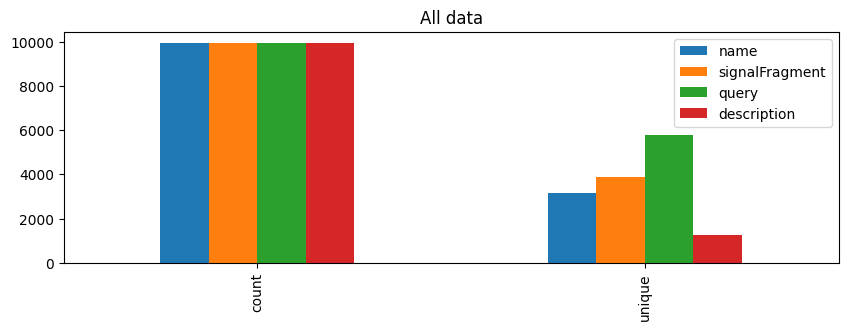

In [69]:
# number of unique records
df[['name','signalFragment','query','description']].describe().loc[['count','unique']].plot(kind='bar', title="All data",figsize=(10,3))
df[['name','signalFragment','query','description']].describe().loc[['count','unique']]

### Add columns with length of the signalFragments and WordCount to characterize complexity of the queries

In [70]:
# add  columns with length of the signalFragments
import numpy as np
import string
def words_count(text):
    t=text.replace("("," ").replace(")"," ").replace("["," ").replace("]"," ").replace("{"," ").replace("}"," ")
    return len(''.join([x for x in " ".join(t.split()) if x in string.ascii_letters + '_'+ ' ' or x.isdigit()]).split())
df['description'].replace(np.nan, "", inplace=True) # None in descriptions

df['FragmentWordCount'] = df['signalFragment'].apply(lambda x: words_count(x))
df['descriptionWordCount'] = df['description'].apply(lambda x: words_count(x))
df['nameWordCount'] = df['name'].apply(lambda x: words_count(x))

df['FragmentLength'] = df['signalFragment'].apply(lambda x: len(x))
df['descriptionLength'] = df['description'].apply(lambda x: len(x))
df['nameLength'] = df['name'].apply(lambda x: len(x)) 

df.shape
#df.head(n=3)

(9948, 16)

In [592]:
#mask = df['FragmentLength'] > 1000 
#df[mask]

In [142]:
# get an element
indx=10 #4193
df.loc[[indx]]['signalFragment']
df.loc[[indx]][['name','query','signalFragment']]
#df[['query',"signalFragment","view","origin"]][indx:indx+1].values.tolist()[0]

,name,query,signalFragment
10,FI-AP items released for payment (total lead time),"\nSELECT\nAVG (""4 - Lead time from start - FI-AP items released for payment"")\nFROM ""defaultview-32""\n","SELECT AVG (""4 - Lead time from start - FI-AP items released for payment"") FROM THIS_PROCESS"


### Filter out Signals without descriptions and with None descriptions - new data frame:  DF1

Without None descriptions (9948, 16)
Signals with Non-empty description (4708, 16)


,name,signalFragment,query,description,view
count,4708,4708,4708,4708,4708
unique,1298,1655,3184,1254,35


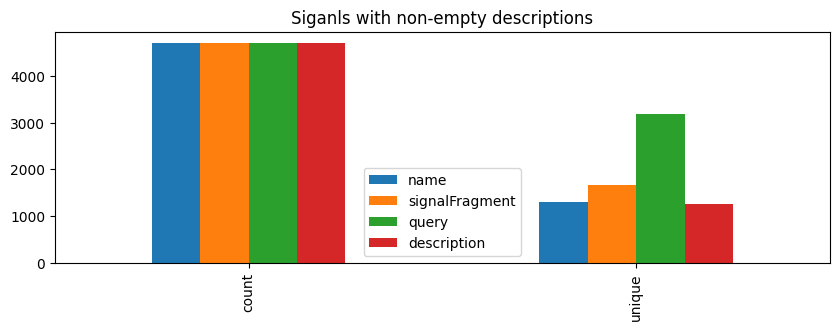

In [75]:
# Filter out Signals without descriptions and with None descriptios
pd.set_option('display.max_colwidth', None)  
new_df = df[~df['description'].isnull()]
print("Without None descriptions", new_df.shape)

df1=new_df[new_df['description'] != "" ]
#df1=new_df
print("Signals with Non-empty description",df1.shape)
figsize=(10,3)
df1[['name','signalFragment','query','description']].describe().loc[['count','unique']].plot(kind='bar',title="Siganls with non-empty descriptions",figsize=figsize)
df1[['name','signalFragment','query','description','view']].describe().loc[['count','unique']]


### Drop duplicates in DF1

In [76]:
# Drop duplicates
print(df1.shape)
columns=['name','description','signalFragment'] # 1702
#columns=['name','description']                  # 1409 
#columns=['name','signalFragment']               # 1620
df1.drop_duplicates(columns, keep='first',inplace=True)
print(df1.shape)
df1[['name','description','signalFragment','view']].describe().loc[['count','unique']]


(4708, 16)
(1946, 16)


/var/folders/hb/_ptqrx710ljb_2f6664d20bh0000gn/T/ipykernel_35105/959564203.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop_duplicates(columns, keep='first',inplace=True)


,name,description,signalFragment,view
count,1946,1946,1946,1946
unique,1298,1254,1655,28


In [78]:
df1.head(n=3)

,name,query,description,meta,metric_vars,view,signalFragment,process,origin,workspace_name,FragmentWordCount,descriptionWordCount,nameWordCount,FragmentLength,descriptionLength,nameLength
0,Total number of created incidents,"\nSELECT\nCOUNT(case_id)\nFROM ""defaultview-545""\n",Total number of created incidents,metric,{},defaultview-545,SELECT COUNT(case_id) FROM THIS_PROCESS,../data/metric_definitions/incident_to_resolution.json,../data/metric_definitions/incident_to_resolution.json,Solutions Demo Workspace,5,5,5,39,33,33
1,Total number of open incidents,"\nSELECT\nCOUNT(case_id) FILTER (WHERE \n\t(SELECT BOOL_AND(\n NOT event_name IN ('Close Incident')))\n)\nFROM ""defaultview-545""\n",Total number of open incidents,metric,"{'incident_closure_events': {'name': 'incident_closure_events', 'description': 'Events defining the closing events of a case, for example 'Close Incident'', 'defaultValues': [{'defaultValue': ""'Close Incident'"", 'sourceSystems': ['SERVICENOW']}], 'value': ''Close Incident''}}",defaultview-545,SELECT COUNT(case_id) FILTER (WHERE \n\t(SELECT BOOL_AND(\n NOT event_name IN (${incident_closure_events})))\n) FROM THIS_PROCESS,../data/metric_definitions/incident_to_resolution.json,../data/metric_definitions/incident_to_resolution.json,Solutions Demo Workspace,13,5,5,125,30,30
2,Total number of resolved incidents,"\nSELECT\nCOUNT(case_id) FILTER (WHERE \n\t(SELECT BOOL_OR(\n event_name IN ('Close Incident')))\n)\nFROM ""defaultview-545""\n",Total number of resolved incidents,metric,"{'incident_closure_events': {'name': 'incident_closure_events', 'description': 'Events defining the closing events of a case, for example 'Close Incident'', 'defaultValues': [{'defaultValue': ""'Close Incident'"", 'sourceSystems': ['SERVICENOW']}], 'value': ''Close Incident''}}",defaultview-545,SELECT COUNT(case_id) FILTER (WHERE \n\t(SELECT BOOL_OR(\n event_name IN (${incident_closure_events})))\n) FROM THIS_PROCESS,../data/metric_definitions/incident_to_resolution.json,../data/metric_definitions/incident_to_resolution.json,Solutions Demo Workspace,12,5,5,120,34,34


## Validate pandas col with signals against log on dataFrame DF1

**11mins** :API validation for 1702 took: 0.38511105219709885 per signal call


In [ ]:
#>>>>>>>>>>>> olD<<<<<<<<<<<

### Check various option to get signals 

In [81]:
# Signals from metric file
path="../data/metric_definitions/SLAs.json"
#path="experiment00/test001/metrics/metrics.json"
docs_from_metric_json(path, from_json=None, view="strview-1") #[path][0]['metric_vars']

Number of Metrics Signals: 4 in: ../data/metric_definitions/SLAs.json


{'../data/metric_definitions/SLAs.json': [{'name': 'SLA breach ratio on process level, based on SLA events',
   'query': '\nSELECT\nCOUNT(case_id) FILTER (\n\tWHERE (SELECT FIRST(event_name)\n\t\t\tWHERE event_name IN (\'Incident Resolution SLA Breached\',\'Incident Response SLA Breached\')) IS NOT NULL)\n/ COUNT(case_id)\n* 100\nFROM "strview-1"\n                ',
   'description': 'Percentage of cases where the SLA was breached, based on events related to SLA breaches',
   'meta': 'metric',
   'metric_vars': {'sla_breach_events': {'name': 'sla_breach_events',
     'description': "Events indicating the breach of an SLA, for example 'Incident Resolution SLA Breached'",
     'defaultValues': [{'defaultValue': "'Incident Resolution SLA Breached','Incident Response SLA Breached'",
       'sourceSystems': ['SERVICENOW'],
       'processTypes': ['INCIDENT_TO_RESOLUTION']}],
     'value': "'Incident Resolution SLA Breached','Incident Response SLA Breached'"}},
   'view': 'strview-1',
   'si

In [83]:
# Signals from metric query json
path='test001' # 'test001-1'
q_list_metrics['variables']['subjectId']=path
j = POST_Signavio(query=q_list_metrics,auth=auth)['data']
j = all_json[path]['list_metrics']
docs_from_metric_json(path, from_json=j, view="strview-1") #[path][0]['metric_vars']['sla_closure_events'] 

KeyError: ''

In [350]:
# From Dashboard file
path="../../data/SignavioText2Signal/dashboards/pia-dashboards/source-to-pay/Procure to Pay for ECC & S4H/Late Payments.json"
path="experiment00/demo01/dashboards/workingdashboard_2023-11-16.json"
print(path)
docs_from_investigations_dashboard_json(path,from_json=None, sourcekeys=["dashboard","metrics"],view="strview-1")

experiment00/demo01/dashboards/workingdashboard_2023-11-16.json
Number of metrics Metrics Signals: 0 in: experiment00/demo01/dashboards/workingdashboard_2023-11-16.json
 Number of dashboard Signals: 1 in: experiment00/demo01/dashboards/workingdashboard_2023-11-16.json


{'experiment00/demo01/dashboards/workingdashboard_2023-11-16.json': [{'name': 'w1',
   'query': 'SELECT count(case_id) FROM "strview-1"',
   'description': '',
   'meta': 'dashboard',
   'metric_vars': '',
   'view': 'strview-1',
   'signalFragment': 'SELECT count(case_id) FROM THIS_PROCESS',
   'process': 'experiment00/demo01/dashboards/workingdashboard_2023-11-16.json'}]}

In [357]:
# From Investigation file
path="../../data/SignavioText2Signal/NLP POC (JustAsk)/04 PI Investigation/JustAsk SIGNAL POC - PI Investigation.json"
#path="experiment00/demo01/investigations/AskData POC_2023-11-15.json"
print(path)
i=docs_from_investigations_dashboard_json(path,from_json=None, sourcekeys=["investigation","metrics"],view="strview-1")[path]
len(i)

../../data/SignavioText2Signal/NLP POC (JustAsk)/04 PI Investigation/JustAsk SIGNAL POC - PI Investigation.json
Number of metrics Metrics Signals: 0 in: ../../data/SignavioText2Signal/NLP POC (JustAsk)/04 PI Investigation/JustAsk SIGNAL POC - PI Investigation.json
 Number of investigation Signals: 14 in: ../../data/SignavioText2Signal/NLP POC (JustAsk)/04 PI Investigation/JustAsk SIGNAL POC - PI Investigation.json


14